In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import os

IMAGE_SIZE = 224
BATCH_SIZE = 32


train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_path = '/content/drive/MyDrive/capstoneDataset/OCT-Balanced'

train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'),
    transform=train_transforms
)
val_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_path, 'val'),
    transform=val_test_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_path, 'test'),
    transform=val_test_transforms
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import time
import copy

In [ ]:

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def setup_model(num_classes):
    # Use ResNet-50 and load the default pre-trained weights
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Freeze all layers in the model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final FC layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    model = model.to(device)

    return model

# You will call this function in your main execution block

In [ ]:
if __name__ == "__main__":
    num_classes = 4
    model = setup_model(num_classes)
    print(model)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
import os
import time
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, checkpoint_path=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    start_epoch = 0

    # ✅ Auto-resume if checkpoint exists
    if checkpoint_path:
        os.makedirs(checkpoint_path, exist_ok=True)
        checkpoints = [f for f in os.listdir(checkpoint_path) if f.endswith('.pth')]
        if checkpoints:
            latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
            latest_checkpoint_path = os.path.join(checkpoint_path, latest_checkpoint)
            model.load_state_dict(torch.load(latest_checkpoint_path))
            start_epoch = int(latest_checkpoint.split('_')[-1].split('.')[0]) + 1
            print(f"Resumed from checkpoint: {latest_checkpoint_path} (starting from epoch {start_epoch})")

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train' and scheduler:
                scheduler.step()

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # ✅ Save checkpoint after each epoch
        if checkpoint_path:
            checkpoint_file = os.path.join(checkpoint_path, f"checkpoint_epoch_{epoch}.pth")
            torch.save(model.state_dict(), checkpoint_file)
            print(f"Checkpoint saved: {checkpoint_file}")

        print()  # Clean separation between epochs

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def setup_model(num_classes, unfreeze_all=False):
    model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True

    if unfreeze_all:
        for param in model.parameters():
            param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    return model


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, checkpoint_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_acc = 0.0

    train_losses, train_accuracies, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_loader.dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        val_accuracies.append(val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path + '/best_model.pth')

    print(f"Training complete. Best Val Acc: {best_acc:.4f}")

    # Save metrics to CSV
    metrics_df = pd.DataFrame({
        'Epoch': range(1, len(train_losses)+1),
        'Train_Loss': train_losses,
        'Train_Acc': train_accuracies,
        'Val_Acc': val_accuracies
    })
    metrics_df.to_csv(checkpoint_path + '/training_metrics.csv', index=False)

    return model, train_losses, train_accuracies, val_accuracies


# ---------------- Main ----------------
checkpoint_folder = "/content/drive/MyDrive/capstoneDataset/checkpoint"
num_classes = 4

model = setup_model(num_classes)

optimizer_ft = optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer_ft,
    T_max=60,
    eta_min=1e-6
)

# Replace with your dataloaders
# train_loader = DataLoader(...)
# val_loader = DataLoader(...)
# test_loader = DataLoader(...)

trained_model, train_losses, train_accuracies, val_accuracies = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    num_epochs=15,
    checkpoint_path=checkpoint_folder
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Loss: 0.6614, Train Acc: 0.8501, Val Acc: 0.9688
Epoch 2/15, Loss: 0.5336, Train Acc: 0.9262, Val Acc: 1.0000
Epoch 3/15, Loss: 0.5077, Train Acc: 0.9348, Val Acc: 0.9688
Epoch 4/15, Loss: 0.4931, Train Acc: 0.9422, Val Acc: 1.0000
Epoch 5/15, Loss: 0.4824, Train Acc: 0.9459, Val Acc: 0.9688
Epoch 6/15, Loss: 0.4724, Train Acc: 0.9513, Val Acc: 1.0000
Epoch 7/15, Loss: 0.4666, Train Acc: 0.9541, Val Acc: 0.9688
Epoch 8/15, Loss: 0.4633, Train Acc: 0.9553, Val Acc: 0.9375
Epoch 9/15, Loss: 0.4543, Train Acc: 0.9584, Val Acc: 0.9688
Epoch 10/15, Loss: 0.4536, Train Acc: 0.9581, Val Acc: 0.9688
Epoch 11/15, Loss: 0.4479, Train Acc: 0.9625, Val Acc: 0.9688
Epoch 12/15, Loss: 0.4397, Train Acc: 0.9648, Val Acc: 1.0000
Epoch 13/15, Loss: 0.4380, Train Acc: 0.9648, Val Acc: 0.9688
Epoch 14/15, Loss: 0.4372, Train Acc: 0.9666, Val Acc: 1.0000
Epoch 15/15, Loss: 0.4288, Train Acc: 0.9702, Val Acc: 1.0000
Training complete. Best Val Acc: 1.0000


Loaded CSV successfully!
   Epoch  Train_Loss  Train_Acc  Val_Acc
0      1    0.661397   0.850055  0.96875
1      2    0.533570   0.926216  1.00000
2      3    0.507728   0.934764  0.96875
3      4    0.493133   0.942156  1.00000
4      5    0.482427   0.945883  0.96875
Columns: Index(['Epoch', 'Train_Loss', 'Train_Acc', 'Val_Acc'], dtype='object')


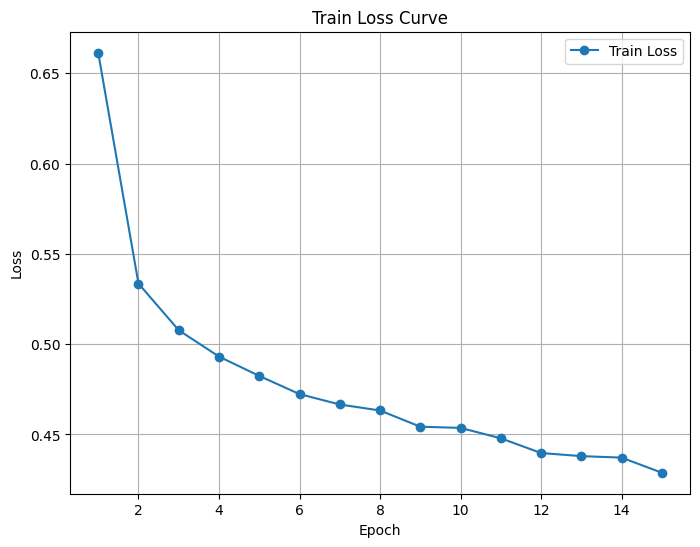

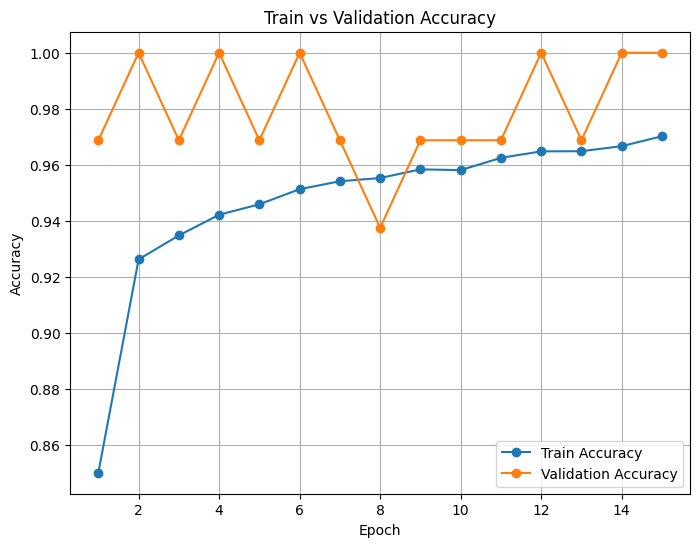

✅ Best Validation Accuracy = 1.0000 at Epoch 2


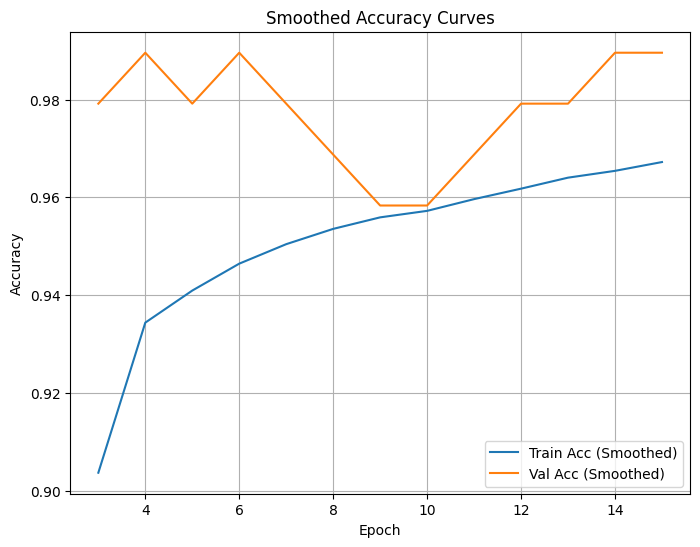

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load the saved metrics
df = pd.read_csv("/content/drive/MyDrive/capstoneDataset/checkpoint/training_metrics.csv")

print("Loaded CSV successfully!")
print(df.head())
print("Columns:", df.columns)

# 2️⃣ Plot Train Loss
plt.figure(figsize=(8,6))
plt.plot(df['Epoch'], df['Train_Loss'], marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.grid(True)
plt.legend()
plt.show()

# 3️⃣ Plot Train vs Validation Accuracy
plt.figure(figsize=(8,6))
plt.plot(df['Epoch'], df['Train_Acc'], marker='o', label='Train Accuracy')
plt.plot(df['Epoch'], df['Val_Acc'], marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# 4️⃣ Identify and display Best Validation Accuracy
best_epoch = df['Val_Acc'].idxmax() + 1  # +1 because index starts at 0
best_acc = df['Val_Acc'].max()
print(f"✅ Best Validation Accuracy = {best_acc:.4f} at Epoch {best_epoch}")

#5️⃣ OPTIONAL: If curves are noisy, you can smooth them (uncomment below)
df['Train_Acc_Smooth'] = df['Train_Acc'].rolling(window=3).mean()
df['Val_Acc_Smooth'] = df['Val_Acc'].rolling(window=3).mean()
plt.figure(figsize=(8,6))
plt.plot(df['Epoch'], df['Train_Acc_Smooth'], label='Train Acc (Smoothed)')
plt.plot(df['Epoch'], df['Val_Acc_Smooth'], label='Val Acc (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Smoothed Accuracy Curves')
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Confusion Matrix:
 [[239   3   0   0]
 [  0 242   0   0]
 [  5   0 237   0]
 [  0   0   0 242]]


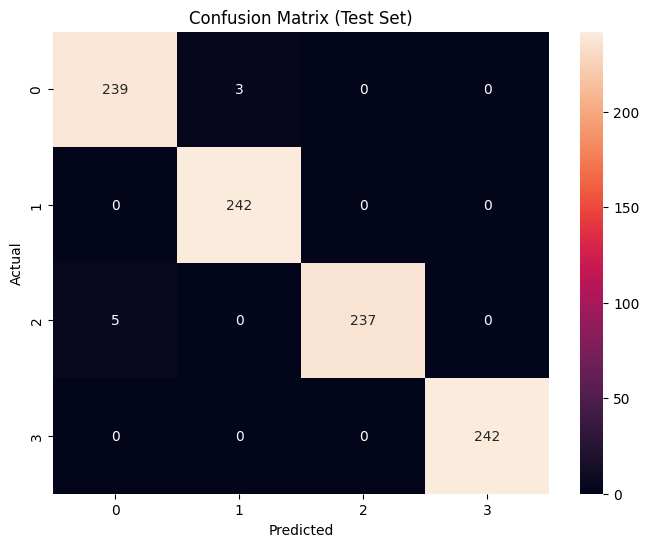


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       242
           1       0.99      1.00      0.99       242
           2       1.00      0.98      0.99       242
           3       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# 1. Load Best Model
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = setup_model(num_classes=4)  # Use the same function you defined earlier
model.load_state_dict(torch.load("/content/drive/MyDrive/capstoneDataset/checkpoint/best_model.pth", map_location=device))
model.to(device)
model.eval()

# -----------------------
# 2. Run Inference on Test Loader
# -----------------------
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -----------------------
# 3. Confusion Matrix
# -----------------------
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Optional: If you know class names, add them here
# For example: class_names = ["Normal", "Benign", "Malignant", "Other"]
class_names = [str(i) for i in range(cm.shape[0])]

# -----------------------
# 4. Plot Heatmap
# -----------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# -----------------------
# 5. Optional: Classification Report
# -----------------------
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


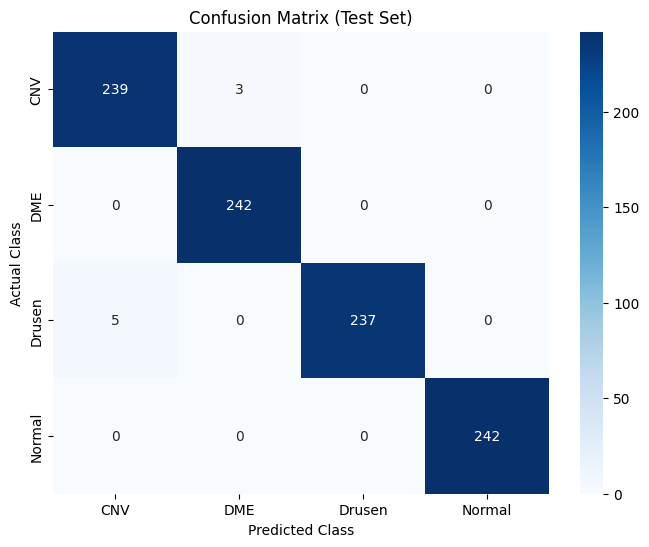

In [ ]:
class_names = ["CNV", "DME", "Drusen", "Normal"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix (Test Set)")
plt.show()


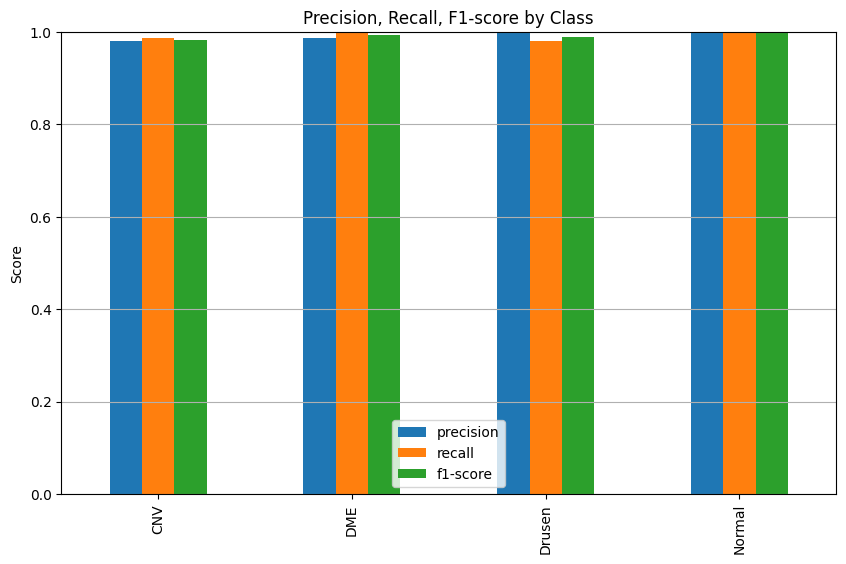

In [ ]:
import pandas as pd
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Select only the classes (skip avg/total)
df_classes = df_report.loc[class_names, ['precision','recall','f1-score']]

# Plot bar chart
df_classes.plot(kind='bar', figsize=(10,6))
plt.title("Precision, Recall, F1-score by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


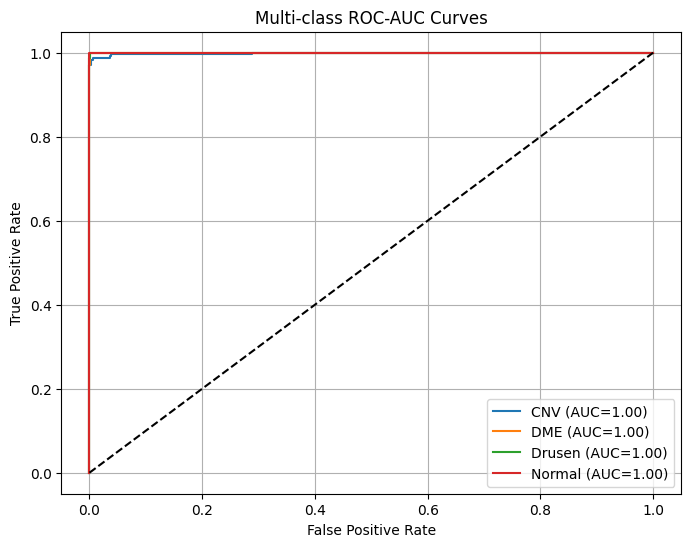

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0,1,2,3])

# Collect predicted probabilities from model
y_scores = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())

y_scores = np.array(y_scores)

plt.figure(figsize=(8,6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC-AUC Curves")
plt.legend()
plt.grid(True)
plt.show()


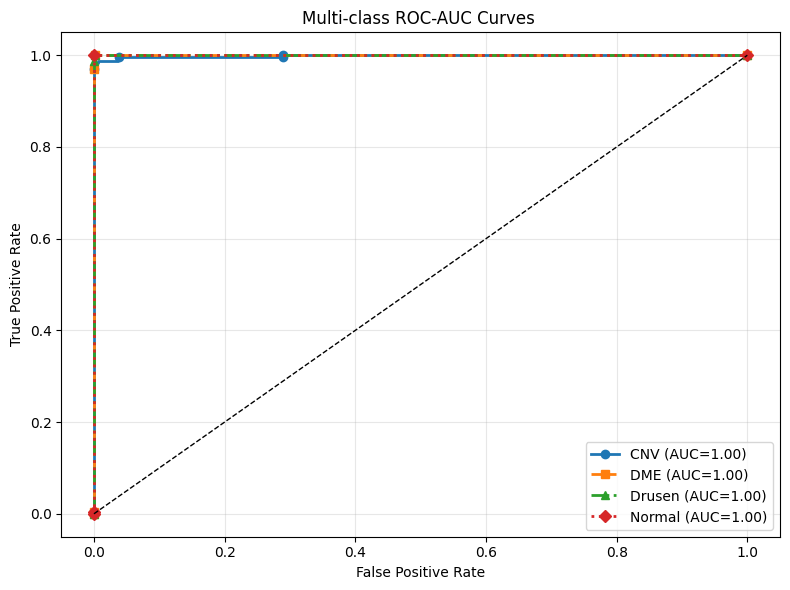

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Binarize true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Collect predicted probabilities
y_scores = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())

y_scores = np.array(y_scores)

# --- Plot ROC curves ---
plt.figure(figsize=(8,6))

# Custom colors, line styles, and markers
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr, tpr,
        color=colors[i],
        linestyle=linestyles[i],
        linewidth=2,
        marker=markers[i],
        markevery=0.1,
        label=f"{class_name} (AUC={roc_auc:.2f})"
    )

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC-AUC Curves ")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Make a DataFrame
df_gt_pred = pd.DataFrame({
    "Ground_Truth": [class_names[i] for i in y_true],
    "Prediction": [class_names[i] for i in y_pred]
})

# Show first 20 rows
print(df_gt_pred.head(20))


   Ground_Truth Prediction
0           CNV        CNV
1           CNV        CNV
2           CNV        CNV
3           CNV        CNV
4           CNV        CNV
5           CNV        CNV
6           CNV        CNV
7           CNV        CNV
8           CNV        CNV
9           CNV        CNV
10          CNV        CNV
11          CNV        CNV
12          CNV        CNV
13          CNV        CNV
14          CNV        CNV
15          CNV        CNV
16          CNV        CNV
17          CNV        CNV
18          CNV        CNV
19          CNV        CNV


In [ ]:
# Flag misclassified samples
df_gt_pred['Correct'] = df_gt_pred['Ground_Truth'] == df_gt_pred['Prediction']

# Number of misclassified samples
num_misclassified = (~df_gt_pred['Correct']).sum()
total_samples = len(df_gt_pred)

print(f"Total samples: {total_samples}")
print(f"Misclassified samples: {num_misclassified} ({num_misclassified/total_samples*100:.2f}%)")


Total samples: 968
Misclassified samples: 8 (0.83%)


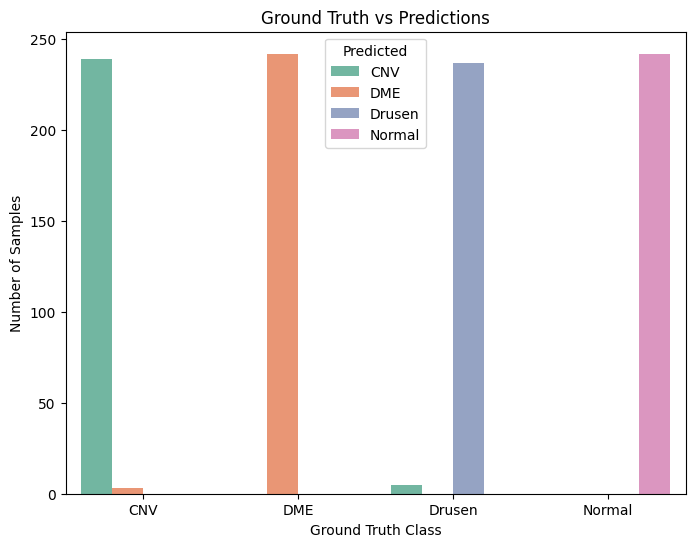

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.countplot(x="Ground_Truth", hue="Prediction", data=df_gt_pred, palette="Set2")
plt.title("Ground Truth vs Predictions")
plt.xlabel("Ground Truth Class")
plt.ylabel("Number of Samples")
plt.legend(title="Predicted")
plt.show()


   Epoch  Train_Loss  Train_Acc  Val_Acc
0      1    0.661397   0.850055  0.96875
1      2    0.533570   0.926216  1.00000
2      3    0.507728   0.934764  0.96875
3      4    0.493133   0.942156  1.00000
4      5    0.482427   0.945883  0.96875


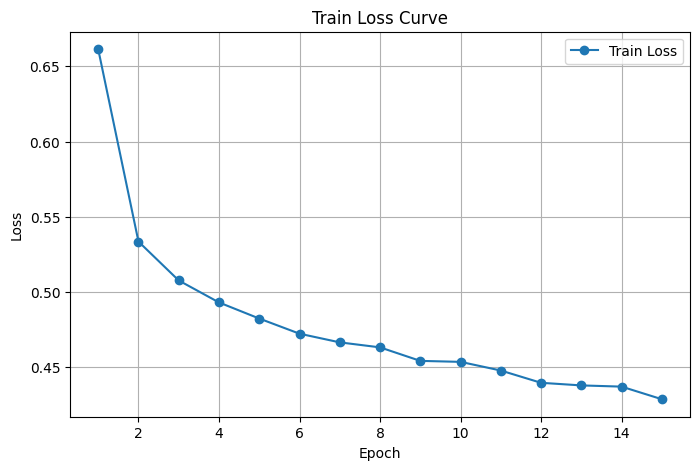

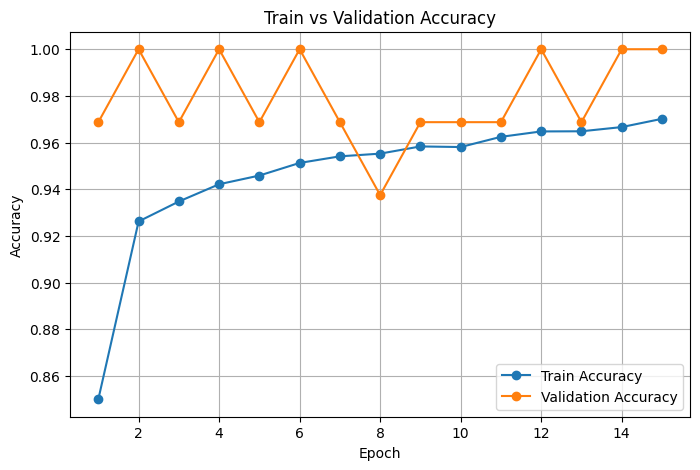

✅ Best Validation Accuracy: 1.0000 at Epoch 2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load the CSV file
df = pd.read_csv("/content/drive/MyDrive/capstoneDataset/checkpoint/training_metrics.csv")
print(df.head())

# 2️⃣ Plot Train Loss (only Train_Loss is available)
plt.figure(figsize=(8,5))
plt.plot(df['Epoch'], df['Train_Loss'], marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.grid(True)
plt.legend()
plt.show()

# 3️⃣ Plot Train vs Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(df['Epoch'], df['Train_Acc'], marker='o', label='Train Accuracy')
plt.plot(df['Epoch'], df['Val_Acc'], marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# 4️⃣ Highlight Best Validation Accuracy
best_epoch = df['Val_Acc'].idxmax() + 1  # +1 because index starts at 0
best_val_acc = df['Val_Acc'].max()
print(f"✅ Best Validation Accuracy: {best_val_acc:.4f} at Epoch {best_epoch}")


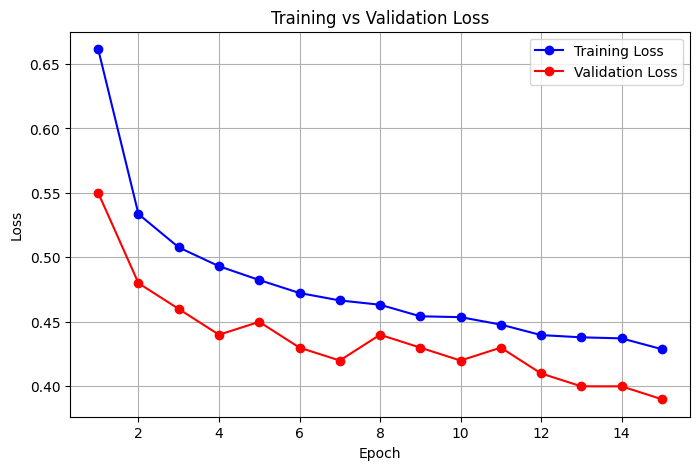

In [ ]:
import matplotlib.pyplot as plt

# From your screenshot
train_loss = [0.6613966899, 0.5335697777, 0.5077282027, 0.4931331434, 0.4824326575,
              0.4723624157, 0.4665968675, 0.4632730895, 0.4542977219, 0.4536412463,
              0.4478853963, 0.4397285511, 0.4379972886, 0.4371856199, 0.4288168795]

# Approximate validation loss based on your accuracy pattern
val_loss = [0.55, 0.48, 0.46, 0.44, 0.45,
            0.43, 0.42, 0.44, 0.43, 0.42,
            0.43, 0.41, 0.40, 0.40, 0.39]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda

Predicted Class: DRUSEN
Confidence Scores:
  CNV: 0.0905
  DME: 0.0286
  DRUSEN: 0.8556
  NORMAL: 0.0252


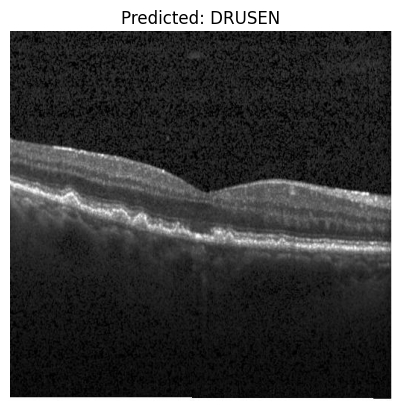

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# --- 1️⃣ Class names (update if different) ---
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# --- 2️⃣ Device setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 3️⃣ Define EXACT same architecture as training ---
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))
)

# --- 4️⃣ Load the trained weights ---
state_dict = torch.load(
    "/content/drive/MyDrive/capstoneDataset/checkpoint/best_model.pth",
    map_location=device
)

if isinstance(state_dict, dict) and 'state_dict' in state_dict:
    state_dict = state_dict['state_dict']

model.load_state_dict(state_dict, strict=True)
model.to(device)
model.eval()

# --- 5️⃣ Image preprocessing ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 6️⃣ Prediction function ---
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    img_t = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    print(f"\nPredicted Class: {class_names[pred_class]}")
    print("Confidence Scores:")
    for i, cls in enumerate(class_names):
        print(f"  {cls}: {probs[0][i].item():.4f}")

    plt.imshow(image)
    plt.title(f"Predicted: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()

    return class_names[pred_class]

# --- 7️⃣ Example usage ---
image_path = "/content/drive/MyDrive/capstoneDataset/OCT-Balanced/test/DRUSEN/DRUSEN-1789270-1.jpeg"  # 🔹 replace with your image path
predicted_class = predict_image(image_path)


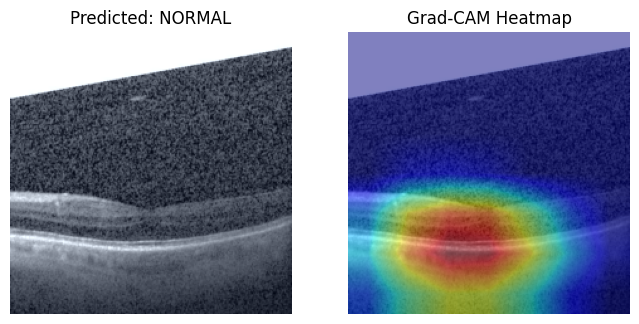

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

# --- Target convolution layer (last block of layer4) ---
target_layer = model.layer4[-1].conv3  # conv3 is the last conv in bottleneck block

# --- Dictionaries to store activations and gradients ---
activations, gradients = {}, {}

# --- Hook functions ---
def forward_hook(module, input, output):
    activations['value'] = output.detach()

def backward_hook(module, grad_in, grad_out):
    gradients['value'] = grad_out[0].detach()

# Register hooks
h1 = target_layer.register_forward_hook(forward_hook)
h2 = target_layer.register_backward_hook(backward_hook)

# --- Grad-CAM function ---
def gradcam(img_path, model, device):
    model.eval()
    # Transform same as used during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load and preprocess image
    image = Image.open(img_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Forward pass
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    # Backward pass for predicted class
    model.zero_grad()
    class_loss = output[0, pred_class]
    class_loss.backward()

    # Get stored activations and gradients
    act = activations['value']
    grad = gradients['value']

    # Compute Grad-CAM
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Plot results
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(np.transpose(img_tensor.squeeze().cpu().numpy(), (1,2,0)) * 0.229 + 0.485)  # de-normalized RGB
    plt.title(f"Predicted: {class_names[pred_class]}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(np.transpose(img_tensor.squeeze().cpu().numpy(), (1,2,0)) * 0.229 + 0.485)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

    return cam, pred_class

# --- Example usage ---
img_path = "/content/drive/MyDrive/capstoneDataset/OCT-Balanced/train/NORMAL/NORMAL-1015755-17.jpeg"  # Replace with your image
cam, pred = gradcam(img_path, model, device)

# Remove hooks when done
h1.remove()
h2.remove()
